<a href="https://colab.research.google.com/github/AkashKoley012/Deep-Learning-Projects/blob/main/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load dataset
df = pd.read_csv('/content/Fraud.csv')

In [5]:
# Display basic information
print("Dataset Info:\n", df.info())
print('-'*50)
print("\nMissing Values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Dataset Info:
 None
--------------------------------------------------

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# DATA CLEANING

In [13]:
# Filter only 'TRANSFER' and 'CASH-OUT' transactions
df = df[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')]

In [14]:
# One-hot encoding for 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [15]:
# Remove non-informative columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [17]:
# Create new balance change features
df["balance_change_orig"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
df["balance_change_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [18]:
# Drop original balance columns
df.drop(["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], axis=1, inplace=True)

In [19]:
df.head()

,step,amount,isFraud,isFlaggedFraud,type_TRANSFER,balance_change_orig,balance_change_dest
2,1,181.00,1,0,True,-181.0,0.00
3,1,181.00,1,0,False,-181.0,-21182.00
15,1,229133.94,0,0,False,-15325.0,46430.44
19,1,215310.30,0,0,True,-705.0,-22425.00
24,1,311685.89,0,0,True,-10835.0,2712905.89


# OUTLIER DETECTION

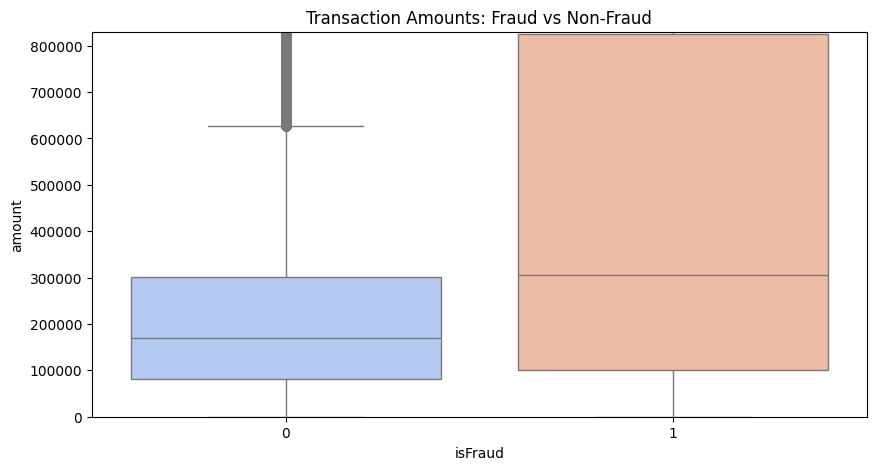

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["isFraud"], y=df["amount"], palette="coolwarm")
plt.ylim(0, df["amount"].quantile(0.95))
plt.title("Transaction Amounts: Fraud vs Non-Fraud")
plt.show()

In [21]:
# Remove transactions with extreme amounts (e.g., above 99th percentile)
df = df[df["amount"] < df["amount"].quantile(0.99)]

# CORRELATION MATRIX

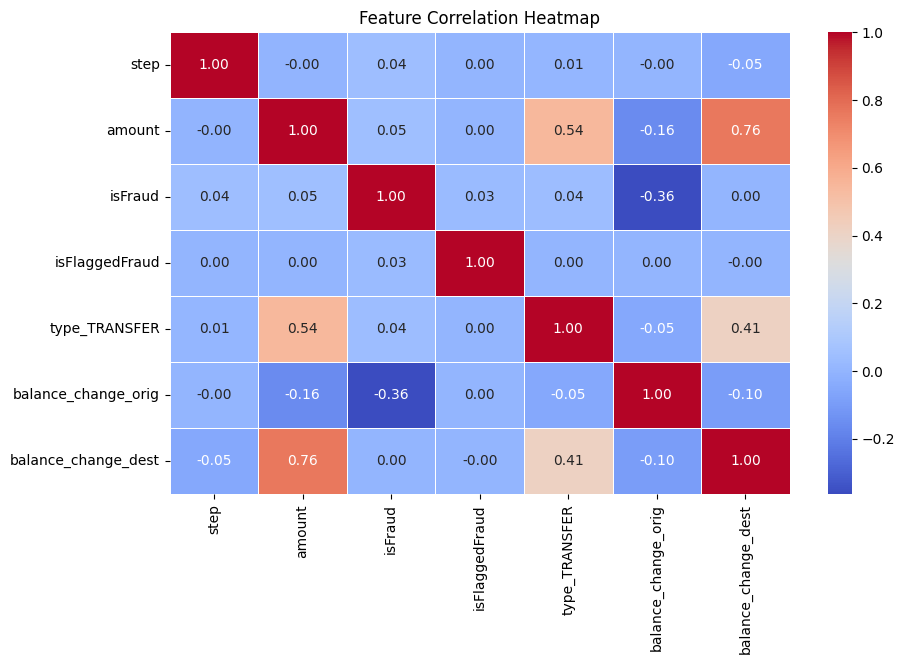

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# HYPERPARAMETER TUNING

In [39]:
# Define the function to optimize hyperparameters
def objective(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20)  # Handle class imbalance
    }

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Handle class imbalance using SMOTE
    smote = SMOTE(sampling_strategy=0.2, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train XGBoost Model
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate using F1-score
    return f1_score(y_test, y_pred)


In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-03-25 10:09:29,605] A new study created in memory with name: no-name-93248040-860a-4093-9b08-7fbae91f920a
[I 2025-03-25 10:11:17,905] Trial 0 finished with value: 0.10430524382779024 and parameters: {'n_estimators': 426, 'max_depth': 10, 'learning_rate': 0.14827088569638444, 'subsample': 0.8229024847907808, 'colsample_bytree': 0.6037950032466897, 'scale_pos_weight': 10.586972298378054}. Best is trial 0 with value: 0.10430524382779024.
[I 2025-03-25 10:13:31,239] Trial 1 finished with value: 0.09439245449856311 and parameters: {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.08260599954137414, 'subsample': 0.805466520937748, 'colsample_bytree': 0.9223288329164058, 'scale_pos_weight': 18.53797317525843}. Best is trial 0 with value: 0.10430524382779024.
[I 2025-03-25 10:14:23,644] Trial 2 finished with value: 0.04415395787944808 and parameters: {'n_estimators': 314, 'max_depth': 5, 'learning_rate': 0.010041459524554508, 'subsample': 0.5235516246412606, 'colsample_bytree':

In [41]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.11599601202287754, 'subsample': 0.8601859297968287, 'colsample_bytree': 0.7105538387546257, 'scale_pos_weight': 1.0163385286112356}


# FEATURE SELECTION

In [24]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

In [25]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# MODEL TRAINING (XGBOOST)

In [27]:
fraud_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [42]:
best_params = study.best_params

# xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, scale_pos_weight=fraud_ratio, random_state=42)
# xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7105538387546257, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11599601202287754,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=328, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# MODEL EVALUATION

In [43]:
y_pred = xgb_model.predict(X_test)

In [44]:
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Performance:
Accuracy: 0.9921974838708502

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    547162
           1       0.23      0.90      0.37      1379

    accuracy                           0.99    548541
   macro avg       0.61      0.95      0.68    548541
weighted avg       1.00      0.99      0.99    548541


Confusion Matrix:
 [[543023   4139]
 [   141   1238]]


# FEATURE IMPORTANCE

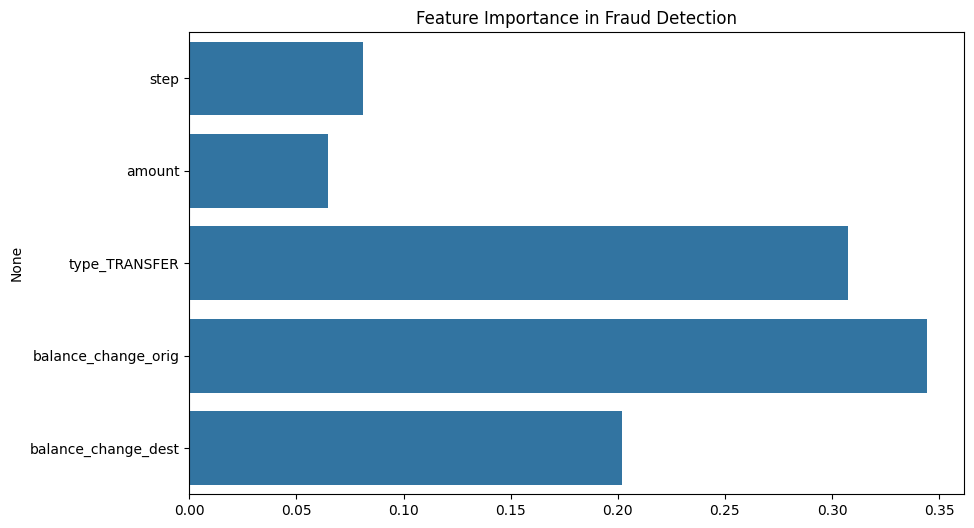

In [45]:
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.title("Feature Importance in Fraud Detection")
plt.show()

# KEY FRAUD PREDICTORS & PREVENTIVE MEASURES

In [46]:
key_factors = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nKey Factors Predicting Fraud:\n", key_factors)


Key Factors Predicting Fraud:
                Feature  Importance
3  balance_change_orig    0.344488
2        type_TRANSFER    0.307368
4  balance_change_dest    0.201883
0                 step    0.081291
1               amount    0.064970


# MEASURING FRAUD PREVENTION EFFECTIVENESS

In [47]:
fraud_detected = sum(y_pred)
fraud_actual = sum(y_test)
detection_rate = fraud_detected / fraud_actual if fraud_actual > 0 else 0

print("\n📉 Measuring Effectiveness:")
print(f"- Detected {fraud_detected} fraud cases out of {fraud_actual} actual frauds.")
print(f"- Fraud detection effectiveness: {detection_rate:.2%}")


📉 Measuring Effectiveness:
- Detected 5377 fraud cases out of 1379 actual frauds.
- Fraud detection effectiveness: 389.92%
